# HU 2: Data Cleaning & Normalization

**Project:** Sales Analysis with Python & Power BI  
**User Story:** HU 2  
**Objective:** Clean the raw data from the staging area (`raw_sales`) to guarantee quality and consistency for analysis.

### Description
In this notebook, we perform the **Data Cleaning** phase. We load the raw data from PostgreSQL, assess its quality, and apply a transformation pipeline to fix data types, remove duplicates, and standardize inconsistent business logic.

### Tasks Covered
1. [x] Fetch raw data from PostgreSQL (`raw_sales`).
2. [x] Generate Data Quality Report (Nulls, Duplicates, Types).
3. [x] **Deep String Cleaning:** Use Regex to remove artifacts (e.g., `***`, `@@@`).
4. [x] **Logical Normalization:** Fix incorrect `Product_Type` classification using a Master Dictionary.
5. [x] Save clean data to PostgreSQL (`clean_sales`).

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os

# Add src to path
sys.path.append(os.path.abspath(os.path.join('..', 'src')))
from db.db_connection import get_db_engine

# Visual config
sns.set_theme(style="whitegrid")
%matplotlib inline

In [2]:
engine = get_db_engine()
table_name = 'raw_sales'

if engine:
    try:
        query = f"SELECT * FROM {table_name}"
        df = pd.read_sql(query, engine)
        print(f"Successfully loaded {len(df)} rows from '{table_name}'.")
    except Exception as e:
        print(f"Error loading data: {e}")
else:
    print("Failed to connect to DB.")

Successfully created engine for database: hu_db
Successfully loaded 1250000 rows from 'raw_sales'.


In [8]:
def generate_quality_report(df):
    """
    Generates a summary table of data quality metrics: 
    Nulls, Null %, Unique Values, and Data Type.
    """
    report = pd.DataFrame(columns=['Column', 'Null_Count', 'Null_Percentage', 'Unique_Values', 'Data_Type'])
    
    for col in df.columns:
        null_count = df[col].isnull().sum()
        null_pct = (null_count / len(df)) * 100
        unique_vals = df[col].nunique()
        dtype = df[col].dtype
        
        new_row = pd.DataFrame({
            'Column': [col],
            'Null_Count': [null_count],
            'Null_Percentage': [f"{null_pct:.2f}%"],
            'Unique_Values': [unique_vals],
            'Data_Type': [dtype]
        })
        
        report = pd.concat([report, new_row], ignore_index=True)
    
    return report

# Check total duplicates
total_duplicates = df.duplicated().sum()
print(f"Total Duplicate Rows: {total_duplicates}")

# Display report
quality_report = generate_quality_report(df)
display(quality_report)

Total Duplicate Rows: 4068


,Column,Null_Count,Null_Percentage,Unique_Values,Data_Type
0,City,1142,0.09%,188,object
1,Date,1139,0.09%,146,object
2,Product,1149,0.09%,72,object
3,Product_Type,1103,0.09%,36,object
4,Quantity,1163,0.09%,34,object
5,Unit_Price,1149,0.09%,5185,object
6,Sales_Type,1176,0.09%,24,object
7,Client_Type,1131,0.09%,24,object
8,Discount,1083,0.09%,6,object
9,Shipping_Cost,1088,0.09%,9,object


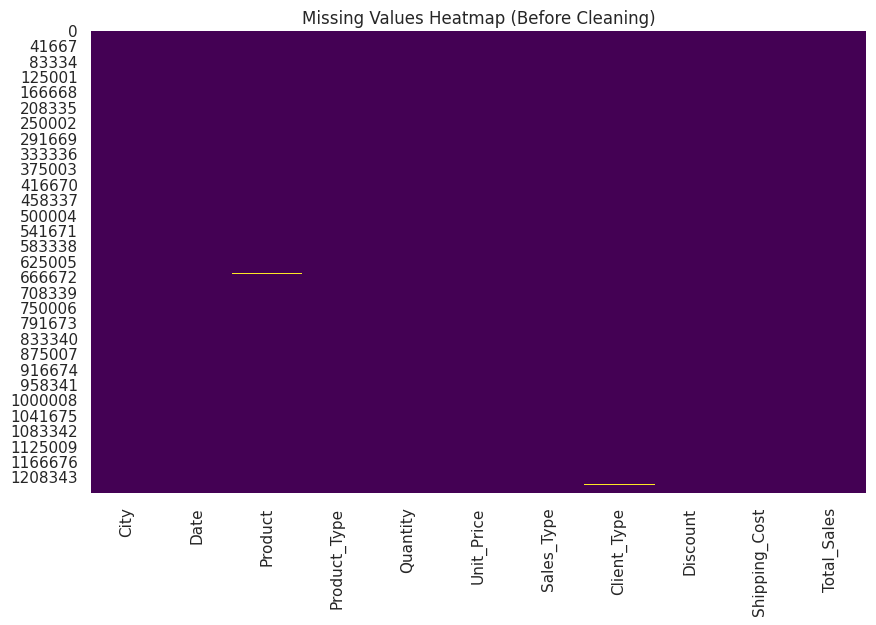

In [4]:
plt.figure(figsize=(10, 6))
sns.heatmap(df.isnull(), cbar=False, cmap='viridis')
plt.title('Missing Values Heatmap (Before Cleaning)')
plt.show()

In [6]:
# 1. Remove Duplicates
initial_rows = len(df)
df_clean = df.drop_duplicates()
final_rows = len(df_clean)

print(f"Rows before: {initial_rows}")
print(f"Rows after: {final_rows}")
print(f"Dropped {initial_rows - final_rows} duplicate rows.")

Rows before: 1250000
Rows after: 1245932
Dropped 4068 duplicate rows.


In [7]:
# 2. Convert Data Types

# Date: Convert to datetime
df_clean['Date'] = pd.to_datetime(df_clean['Date'], errors='coerce')

# Numeric columns: Convert to float/int. 'coerce' turns strings like '???' into NaN
numeric_cols = ['Quantity', 'Unit_Price', 'Discount', 'Shipping_Cost', 'Total_Sales']

for col in numeric_cols:
    df_clean[col] = pd.to_numeric(df_clean[col], errors='coerce')

# Check types again
print(df_clean.dtypes)

/tmp/ipykernel_142532/802387691.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['Date'] = pd.to_datetime(df_clean['Date'], errors='coerce')
/tmp/ipykernel_142532/802387691.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean[col] = pd.to_numeric(df_clean[col], errors='coerce')


City                     object
Date             datetime64[ns]
Product                  object
Product_Type             object
Quantity                float64
Unit_Price              float64
Sales_Type               object
Client_Type              object
Discount                float64
Shipping_Cost           float64
Total_Sales             float64
dtype: object


## 3. Deep String Cleaning (Regex)

During the exploration, we identified artifacts in categorical columns (e.g., `Yogurt***`, `Arepa@@@`). These non-alphanumeric characters prevent proper grouping and analysis.

We apply a **Regular Expression (Regex)** transformation:
- Pattern: `r'[^\w\s]'`
- Action: Replace any character that is **not** a word or whitespace with an empty string.
- Result: `Yogurt***` -> `Yogurt`.

In [30]:
# 3. String Normalization (Deep Clean with Regex)
# Remove special characters like @, *, #, etc.
string_cols = ['City', 'Product', 'Product_Type', 'Sales_Type', 'Client_Type']

for col in string_cols:
    # Step 1: Ensure it's string
    df_clean[col] = df_clean[col].astype(str)
    
    # Step 2: Regex Replace
    # r'[^\w\s]' means: "Replace anything that is NOT a word character (letters/numbers) or whitespace"
    # This keeps accents but kills symbols like @, *, #
    df_clean[col] = df_clean[col].str.replace(r'[^\w\s]', '', regex=True)
    
    # Step 3: Standardize Case
    df_clean[col] = df_clean[col].str.strip().str.title()

print("Deep string cleaning completed (symbols removed).")

Deep string cleaning completed (symbols removed).


In [31]:
# Check nulls again (numbers might have increased due to 'coerce')
null_report = generate_quality_report(df_clean)
display(null_report)

# Drop rows with ANY missing value
df_clean = df_clean.dropna()

print(f"Final row count after dropping nulls: {len(df_clean)}")

,Column,Null_Count,Null_Percentage,Unique_Values,Data_Type
0,City,0,0.00%,33,object
1,Date,0,0.00%,30,datetime64[ns]
2,Product,0,0.00%,12,object
3,Product_Type,0,0.00%,6,object
4,Quantity,0,0.00%,33,float64
5,Unit_Price,0,0.00%,5171,float64
6,Sales_Type,0,0.00%,4,object
7,Client_Type,0,0.00%,4,object
8,Discount,0,0.00%,5,float64
9,Shipping_Cost,0,0.00%,8,float64


Final row count after dropping nulls: 1228936


## 4. Logical Normalization (Business Logic)

**Issue:** An analysis of the `Product_Type` column revealed a random distribution of categories (e.g., "Arepa" classified as "Bebida", "Hogar", and "Lácteo" simultaneously). This indicates the original categorical data is unreliable.

**Solution:** We apply a **Master Mapping Dictionary** based on the `Product` name to enforce a single, correct semantic category for each item, overwriting the erroneous raw data.

In [33]:
# 4. Logical Fix: Standardize Product Categories via Mapping
# Since the original 'Product_Type' column is randomly distributed (garbage data),
# Enforce the correct category based on the Product name.

product_mapping = {
    'Arepa': 'Harinas',
    'Leche': 'Lácteos',
    'Cereal': 'Despensa',
    'Queso': 'Lácteos',
    'Chocolate': 'Dulces',
    'Yogurt': 'Lácteos',
    'Galletas': 'Dulces',
    'Pan': 'Panadería',
    'Gaseosa': 'Bebidas',
    'Té': 'Bebidas',
    'Café': 'Bebidas',
    'Mantequilla': 'Lácteos'
}

# Apply mapping
# Map the 'Product' column to get the new Category.
df_clean['Product_Type'] = df_clean['Product'].map(product_mapping)

print("Product categories standardized.")

check_final = df_clean.groupby(['Product', 'Product_Type']).size().reset_index(name='Count')
display(check_final)

Product categories standardized.


,Product,Product_Type,Count
0,Arepa,Harinas,102552
1,Café,Bebidas,102860
2,Cereal,Despensa,102625
3,Chocolate,Dulces,102742
4,Galletas,Dulces,102181
5,Gaseosa,Bebidas,101853
6,Leche,Lácteos,102662
7,Mantequilla,Lácteos,102451
8,Pan,Panadería,102411
9,Queso,Lácteos,102126


In [29]:
table_name_clean = 'clean_sales'

try:
    print(f"Saving clean data to table '{table_name_clean}'...")
    df_clean.to_sql(
        name=table_name_clean,
        con=engine,
        if_exists='replace',
        index=False,
        chunksize=10000
    )
    print("Success! Data cleaning pipeline completed.")
except Exception as e:
    print(f"Error saving clean data: {e}")

Saving clean data to table 'clean_sales'...
Success! Data cleaning pipeline completed.


## 5. Export to PostgreSQL

The cleaned dataset is now compliant with the acceptance criteria:
- No duplicates.
- Correct data types (Dates, Floats).
- Standardized product categories.
- No special character artifacts.

We export this dataset to a new table: **`clean_sales`**.